# Lab 15: MCMC for Feynman Path Integral Tutorial

In the lecture we saw some results from S.Mittal et al, and we will try to reproduce them in the lab today. The Markov chain Monte Carlo (MCMC) method can be used to evaluate the
discrete imaginary-time path integral (an alternative formulation to the path integral) of a quantum harmonic oscillator system with "Euclidean Lagragian" $L_E(x(\tau))=\frac{m}{2}(\frac{dx}{d\tau})^2 +V(x(\tau))$, and we can obtain a histogram of the probability density by summing up the number of times a particle is in a bin. 

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import tqdm

Analytic solution of the Schodinger equation to the ground state wavefunction of a quantum harmonic oscillator is given by: $\psi(x)=(\frac{m\omega}{\pi\hbar})^{1/4} \exp{(-\frac{m\omega}{2\hbar} x^2)}$.

A different approach to solving the Schodinger equation is by evaluating the imaginary-time path integral for this system using the Markov chain Monte Carlo (MCMC) method.


The path is assigned along a time lattice to $N_{xbins} =100$ spatial bins ranging in $[-4,4]$ with width $\Delta x$. Choose time lattice with $N_{\tau} = 30$ time increments $\delta\tau$ with lattice points $x_n = n\delta \tau$ for $n = 0,1,2,...,N_{\tau}$, over $n_{sweeps} = 20,000$, hitsize $h = 0.1$, and set $m=\hbar=1=\omega$. Periodic boundary condition is imposed on the lattice. 


In [2]:
SWEEPS = 20_000
H = 1
OMEGA = 1
M = 1
TAU = 30
DELTATAU = 1
NTAU = int(TAU/DELTATAU)
HITSIZE = 0.1

XLOW = -4
XHIGH = 4
NXBINS = 100
DELTAX = (XHIGH - XLOW) / NXBINS
HITSIZE = 0.1
prob_histogram = np.zeros(NXBINS)
x_bins = np.linspace(XLOW, XHIGH, NXBINS + 1)

x_path = np.zeros(NTAU)
## analytical solution
psi_analytical = (M*OMEGA/(np.pi*H))**0.25*np.exp(-M*OMEGA*x_bins**2/2/H)

We begin with an initial path $x_{path}$, which may be an array of random numbers (‘hot’ start) or zeros (‘cold’ start), and we use the ‘cold’ start for now. This path is updated by applying the Metropolis–Hastings algorithm to each element $x_i$ of the path in random order, called a ‘sweep’. There are two steps in the updating process:
- Generate a uniform random number $u \in [-h, h]$ (where h is called the hitsize)
- Propose the new value $x_i'=x_i +u$ of the path element and calculate the resulting change $\Delta S$ in the action.
If $\Delta S \leq 0$, accept the new path element.
If $\Delta S > 0$, accept with probability $exp(-\Delta S/\hbar)$.

For better performance, we can play with the parameters DELTATAU, HITSIZE, SWEEPS, etc, and we can also add "thinning" where only every Nth sweep is saved. For example:
- if we choose a smaller time step $\delta\tau = 0.1$, we end up with better energy approximation to the ground state; 
- if the hitsize we choose is too large, few changes will be accepted; too small and the exploration of phase space will be slow. How should we choose the hit size wisely?

The action $S(\{x_k\})=\delta\tau\sum_{i=1}^{N_{\tau}}[\frac{m}{2}(\frac{x_{i+1}-x_i}{\delta \tau})^2 +V(x_i)]$, where $V(x_i) = \sum_{i=1}^{N_{\tau}}[\frac{m\omega^2}{2}(\frac{x_{i+1}+x_i}{2})^2]$.
Note that one sweep produces the next path. Each path is determined only by
the immediately preceding path, so the complete sequence of paths forms a Markov chain,
but the paths are correlated.

In [3]:
def vary_path(x_current):
    x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    while x_prime > XHIGH or x_prime < XLOW:
        x_prime = x_current + np.random.random() * 2 * HITSIZE - HITSIZE
    return x_prime

def action(x_left, x_right):
    K = 0.5 * M * (((x_right - x_left))**2) / DELTATAU
    V = 0.5 * M * DELTATAU * (OMEGA**2) * (((x_left + x_right) / 2)**2)
    return K + V

def total_action(x_path):
    path_action = 0
    for i in range(-1, NXBINS-1):
        path_action += action(x_path[i], x_path[i+1])
    return path_action

def delta_action(x_path, x_prime, i):
    x_left = x_path[i-1]
    x_right = x_path[i+1] if i < NTAU-1 else x_path[0] #PBC.
    daction = action(x_left, x_prime) + action(x_prime, x_right) 
    daction -= action(x_left, x_path[i]) + action(x_path[i], x_right) #compute the resulting change from u in delta S.
    return daction

def MCMC(x_path, prob_histogram):
    for i in range(NTAU):
        x_prime = vary_path(x_path[i])
        daction = delta_action(x_path, x_prime, i)
        if daction <= 0:            
            x_path[i] = x_prime
        else:        
            prob = np.exp(-daction)
            if np.random.random() < prob:
                x_path[i] = x_prime
    hist, _ = np.histogram(x_path, bins=x_bins)
    prob_histogram += hist

In [4]:
for k in tqdm.tqdm(range(SWEEPS)):
    MCMC(x_path, prob_histogram)

100%|██████████| 20000/20000 [00:07<00:00, 2765.38it/s]


Finally we get the histogram of the probability density by summing up the number of times a particle is in a bin, and compare it to the analytical solution. We can see the approximation from MCMC is pretty good.

We can now play with the code by plotting the $\langle E\rangle$ observable for each sweep (or equivalently $\langle x^2 \rangle$ vs. iteration) to measure the equilibrium time; or measure the autocorrelation function/autocorrelation time, etc. 

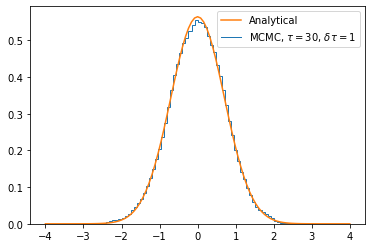

In [5]:
plt.figure()
plt.stairs(prob_histogram/np.sum(prob_histogram*DELTAX), x_bins, label=f"MCMC, $\\tau = {TAU}$, $\\delta\\tau={DELTATAU}$")
plt.plot(x_bins, psi_analytical*psi_analytical.conjugate(), label="Analytical")
plt.legend()
plt.show()